# Data Preprocessing

>1. fill 'NaN' Province/State values with Country/Region values
>2. (optionally) apply log transformation to target values

In [1]:
# load and clean data
import pandas as pd

train_all = pd.read_csv("/root/data/train.csv")

def preprocess(
    frame: pd.DataFrame,
    log_transform: bool = False
):
    
    # set index
    new_frame = frame.set_index('Date')

    # fill 'NaN' Province/State values with Country/Region values
    new_frame['Province/State'] = new_frame['Province/State'].fillna(new_frame['Country/Region'])
    
    # convert target values to log scale
    if log_transform:
        new_frame[['ConfirmedCases', 'Fatalities']] = np.log1p(
            new_frame[['ConfirmedCases', 'Fatalities']].values
    )
    
    return new_frame

def split(
    df: pd.DataFrame, 
    date: str = '2020-03-12'
):
    train = df.loc[train_all.index < date] 
    test = df.loc[train_all.index >= date]
    return train, test

train_all = preprocess(train_all)
train, test = split(train_all)

# Data Exploration

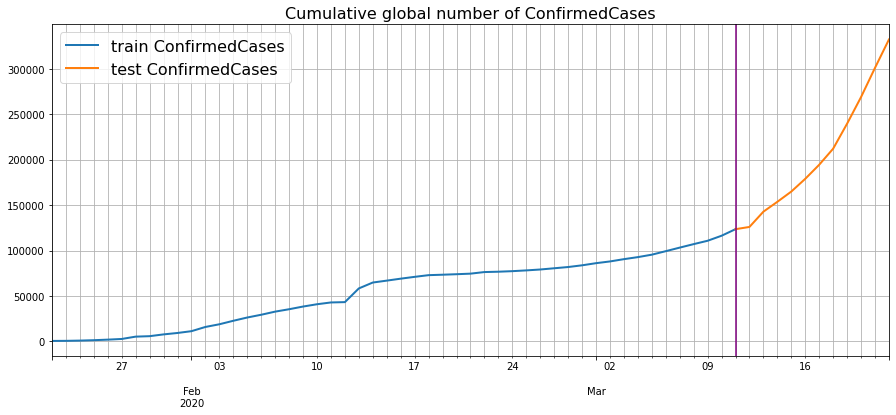

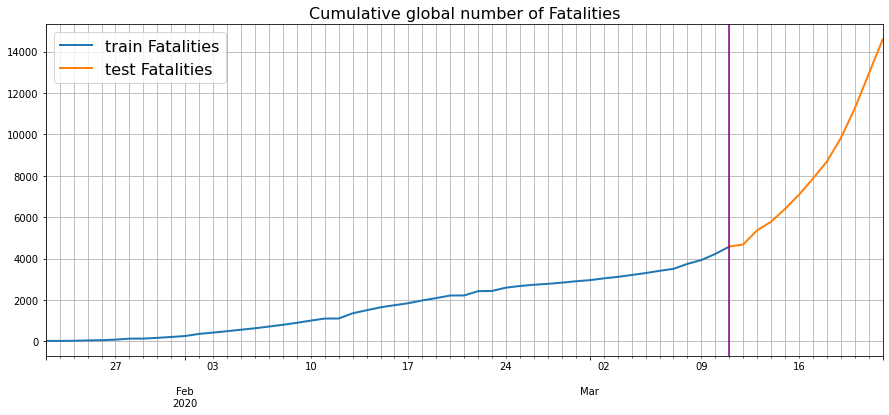

In [2]:
# plot confirmed cases and fatalities in train
import matplotlib.pyplot as plt
from gluonts.dataset.util import to_pandas
from gluonts.dataset.common import ListDataset

cum_train = train.groupby('Date').sum()
cum_test = test.groupby('Date').sum()

def plot_observations(
    target: str = 'ConfirmedCases'
):
    fig = plt.figure(figsize=(15, 6.1), facecolor="white",  edgecolor='k')

    train_ds = ListDataset(
        [{"start": cum_train.index[0], "target": cum_train[target].values}],
        freq = "D",
    )
    test_ds = ListDataset(
        [{"start": cum_test.index[0], "target": cum_test[target].values}],
        freq = "D",
    )
    
    for tr, te in zip(train_ds, test_ds):
        tr = to_pandas(tr)
        te = to_pandas(te)
        tr.plot(linewidth=2, label = f'train {target}')
        tr[-1:].append(te).plot(linewidth=2, label = f'test {target}')
    
    plt.axvline(cum_train.index[-1], color='purple') # end of train dataset
    plt.title(f'Cumulative global number of {target}', fontsize=16)
    plt.legend(fontsize=16)
    plt.grid(which="both")
    plt.show()
    
plot_observations('ConfirmedCases')
plot_observations('Fatalities')

# Data Augmentation

>1. Categorical feature for 'Province/State'
2. Categorical feature for 'Country/Region'
3. Augment with 2020 country level population data from https://www.kaggle.com/tanuprabhu/population-by-country-2020.  This approach was inspired by this previous submission to the competition: https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions:
  1. Population
  2. % Population Increase 2019-2020
  3. Net Population Increase 2019-2020
  4. Population Density (P/Km^2)
  5. Land Area (Km^2)
  6. Net Migration
  7. Fertility Rate
  8. Median Age
  9. % Urban Population
  10. % of World Population
  
**Current Status**: To our surprise, we actually found that the forecasts produced by the DeepAR model were worse with these country-level statistics as additional features. Adding these covariates seemed to bias all forecasts toward 0. We  hypothesize that this is because the distribution of cases/fatalities by province/state for a single country (which has a one-to-many mapping to provinces/states) is right skewed. Thus the model is rewarded for learning the low volume series and the learned parameters and resulting forecasts reflect this. Thus, in the forecasts we have submitted, these country-level statistics have not been included as additional features (see `use_real_vars` argument in `fit()` function defined in this notebook). 

*TODO*:
>1. Experiment with other covariates (state level population data, healthcare infrastructure dataset)

In [8]:
from sklearn.preprocessing import OrdinalEncoder

#pop_df = pd.read_csv('/root/data/population_by_country_2020.csv')

from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer('bert-base-nli-mean-tokens')
country_embeddings = model.encode(list(train['Country/Region'].unique()))
embedding_dim = len(country_embeddings[0])
embed_df = pd.DataFrame(np.concatenate([np.array(list(train['Country/Region'].unique())).reshape(-1,1),country_embeddings],axis=1))
embed_df.columns=['Country/Region']+list(range(embedding_dim))

country_map = {
    "Congo (Brazzaville)": "Congo",
    "Congo (Kinshasa)": "Congo",
    "Cote d'Ivoire": "Côte d'Ivoire",
    "Czechia": "Czech Republic (Czechia)",
    "Gambia, The": "Gambia",
    "Guernsey": "Channel Islands",
    "Jersey": "Channel Islands",
    "Korea, South": "South Korea",
    "Republic of the Congo": "DR Congo",
    "Reunion": "Réunion",
    "Saint Vincent and the Grenadines": "St. Vincent & Grenadines",
    "Taiwan*": "Taiwan",
    "The Bahamas": "Bahamas",
    "The Gambia": "Gambia",
    "US": "United States"
}

def clean_pop_data(
    pop_df: pd.DataFrame
):
    """ bootstrapped from https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions"""
        
    # remove the % character from Urban Pop, World Share, and Yearly Change values 
    pop_df['Yearly Change'] = pop_df['Yearly Change'].str.rstrip('%')
    pop_df['Urban Pop %'] = pop_df['Urban Pop %'].str.rstrip('%')
    pop_df['World Share'] = pop_df['World Share'].str.rstrip('%')
    
    # Replace Urban Pop, Fertility Rate, and Med Age "N.A" by their respective modes
    pop_df.loc[pop_df['Urban Pop %']=='N.A.', 'Urban Pop %'] = pop_df.loc[pop_df['Urban Pop %']!='N.A.', 'Urban Pop %'].mode()[0]
    pop_df.loc[pop_df['Med. Age']=='N.A.', 'Med. Age'] = pop_df.loc[pop_df['Med. Age']!='N.A.', 'Med. Age'].mode()[0]    
    pop_df.loc[pop_df['Fert. Rate']=='N.A.', 'Fert. Rate'] = pop_df.loc[pop_df['Fert. Rate']!='N.A.', 'Fert. Rate'].mode()[0]    
    
    # replace empty migration rows with 0s
    pop_df['Migrants (net)'] =  pop_df['Migrants (net)'].fillna(0)
    
    # cast to types
    pop_df = pop_df.astype({
        "Population (2020)": int,
        "Yearly Change": float,
        "Net Change": int,
        "Density (P/Km²)": int,
        "Land Area (Km²)": int,
        "Migrants (net)": float,
        "Fert. Rate": float,
        "Med. Age": int,
        "Urban Pop %": int,
        "World Share": float,
    })   

    return pop_df

def join(
    df: pd.DataFrame,
    pop_df: pd.DataFrame
):
    
    # add join column with country mapping
    df['join_col'] = [
        val if val not in country_map.keys() 
        else country_map[val] 
        for val in df['Country/Region'].values
    ]
    
    # join, delete merge columns
    new_df = df.reset_index().merge(
        pop_df,
        left_on = 'join_col',
        right_on = 'Country (or dependency)',
        how = 'left'
    ).set_index('Date')
    new_df = new_df.drop(columns=['join_col', 'Country (or dependency)'])
    
    # replace columns that weren't matched in join with mean
    new_df = new_df.fillna(new_df.mean())
    
    return new_df

def join_with_embeddings(
    df: pd.DataFrame,
    embed_df: pd.DataFrame
):
    
    # join, delete merge columns
    new_df = df.reset_index().merge(
        embed_df,
        left_on = 'Country/Region',
        right_on = 'Country/Region',
        how = 'left'
    ).set_index('Date')
    
    # make sure no NaN in dataframe
    assert new_df.isnull().sum().sum()==0
    return new_df

def encode(
    df: pd.DataFrame
):
    """ encode 'Province/State' and 'Country/Region' categorical variables as numerical ordinals"""
    
    enc = OrdinalEncoder()
    df[['Province/State', 'Country/Region']] = enc.fit_transform(
        df[['Province/State', 'Country/Region']].values
    )
    return df, enc

#pop_df = clean_pop_data(pop_df)
#join_df = join(train_all, pop_df)
join_df = join_with_embeddings(train_all, embed_df)

all_df, enc = encode(join_df)
train_df, test_df = split(all_df)
_, val_df = split(all_df, date = '2020-02-28')


INFO:root:Load pretrained SentenceTransformer: bert-base-nli-mean-tokens
INFO:root:Did not find a '/' or '\' in the name. Assume to download model from server.
INFO:root:Load SentenceTransformer from folder: /root/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-base-nli-mean-tokens.zip
INFO:transformers.configuration_utils:loading configuration file /root/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-base-nli-mean-tokens.zip/0_BERT/config.json
INFO:transformers.configuration_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
 

In [5]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
import typing

REAL_VARS = [
    'Population (2020)', 
    'Yearly Change', 
    'Net Change', 
    'Density (P/Km²)', 
    'Land Area (Km²)',
    'Migrants (net)',
    'Fert. Rate',
    'Med. Age',
    'Urban Pop %',
    'World Share'
]

EMBED_VARS = list(range(embedding_dim))

def build_dataset(
    frame: pd.DataFrame,
    target: str = 'Fatalities',
    cat_vars: typing.List[str] = ['Province/State', 'Country/Region'],
    real_vars: typing.List[str] = EMBED_VARS
):
    return ListDataset(
        [
            {
                FieldName.START: df.index[0], 
                FieldName.TARGET: df[target].values,
                FieldName.FEAT_STATIC_CAT: df[cat_vars].values[0],
                FieldName.FEAT_STATIC_REAL: df[real_vars].values[0]
            }
            for g, df in frame.groupby(by=['Province/State', 'Country/Region'])
        ],
        freq = "D",
    )

training_data_fatalities = build_dataset(train_df)
training_data_cases = build_dataset(train_df, target = 'ConfirmedCases')
training_data_fatalities_all = build_dataset(all_df)
training_data_cases_all = build_dataset(all_df, target = 'ConfirmedCases')
val_data_fatalities = build_dataset(val_df)
val_data_cases = build_dataset(val_df, target = 'ConfirmedCases')

# Fit DeepAR Model Estimates

The DeepAR model was proposed by David Salinas, Valentin Flunkert, and Jan Gasthaus in "DeepAR: Probabilistic Forecasting with Autoregressive Recurrent Networks" (https://arxiv.org/abs/1704.04110). The approach trains an autoregressive RNN to produces time-variant parameters of a specified distribution on a large collection of related time series. The learned distribution can then be used to produce probabilistic forecasts. Here we use the authors' *GluonTS* implementation (https://gluon-ts.mxnet.io/index.html).

We believe the probabilistic nature of the DeepAR forecasts is a feature that differentiates our approach from others we have seen so far. Specifically, the ability to provide both confidence intervals and point estimates allows one to better understand the range of possible trajectories, from the worst-case scenario, to the best-case scenario, to the expected scenario. 

*TODO:*
> 1. Experiment with adding learned Box Cox transformation before learning Negative Binomial paramaters?

In [11]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.distribution import NegativeBinomialOutput
import mxnet as mx
import numpy as np

# set random seeds for reproducibility
mx.random.seed(42)
np.random.seed(42)

def fit(
    training_data: ListDataset,
    validation_data: ListDataset = None,
    use_real_vars: bool = True,
    pred_length: int = 14,
    epochs: int = 10,
    weight_decay: float = 5e-5
):
    estimator = DeepAREstimator(
        freq="D", 
        prediction_length=pred_length,
        use_feat_static_real = use_real_vars,
        use_feat_static_cat = True,
        cardinality = [train['Province/State'].nunique(), train['Country/Region'].nunique()],
        distr_output=NegativeBinomialOutput(),
        trainer=Trainer(
            epochs=epochs,
            learning_rate=0.001, 
            batch_size=64,
            weight_decay=weight_decay
        ),
    )
    predictor = estimator.train(training_data = training_data, validation_data = validation_data)
    
    return predictor

predictor_fatalities = fit(training_data_fatalities, val_data_fatalities, epochs=40)
predictor_cases = fit(training_data_cases, val_data_cases, epochs=40)
#predictor_fatalities_all = fit(training_data_fatalities_all, pred_length = 30, epochs=20)
#predictor_cases_all = fit(training_data_cases_all, pred_length = 30, epochs=40)

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:root:Number of parameters in DeepARTrainingNetwork: 186252
100%|██████████| 50/50 [00:11<00:00,  4.40it/s, avg_epoch_loss=0.288]
INFO:root:Epoch[0] Elapsed time 11.357 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.287871
0it [00:00, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 186252
2it [00:00,  5.72it/s, validation_avg_epoch_loss=1.01]
INFO:root:Epoch[0] Elapsed time 0.352 seconds
INFO:root:Epoch[0] Evaluation metric 'validation_epoch_loss'=1.013857
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:11<00:00,  4.18it/s, avg_epoch_loss=0.194]
INFO:root:Epoch[1] Elapsed time 11.961 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.193800
2it [00:00,  4.35it/s, validation_avg_epoch_loss=0.986]
INFO:root:Epoch[1] Elapsed time 0.463 seconds
INFO:root:Epoch[1] Evaluation metric 'validation_epoch_loss'=0.985515
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:10<00:00,  4.62it/s, avg_epoch_loss=0.194]
INFO:

2it [00:00,  8.10it/s, validation_avg_epoch_loss=2.33]
INFO:root:Epoch[20] Elapsed time 0.251 seconds
INFO:root:Epoch[20] Evaluation metric 'validation_epoch_loss'=2.331022
INFO:root:Epoch[21] Learning rate is 0.0005
100%|██████████| 50/50 [00:10<00:00,  4.57it/s, avg_epoch_loss=0.17] 
INFO:root:Epoch[21] Elapsed time 10.937 seconds
INFO:root:Epoch[21] Evaluation metric 'epoch_loss'=0.170324
0it [00:00, ?it/s, validation_avg_epoch_loss=0.656]


KeyboardInterrupt: 

# Plot predictions from fit model parameters

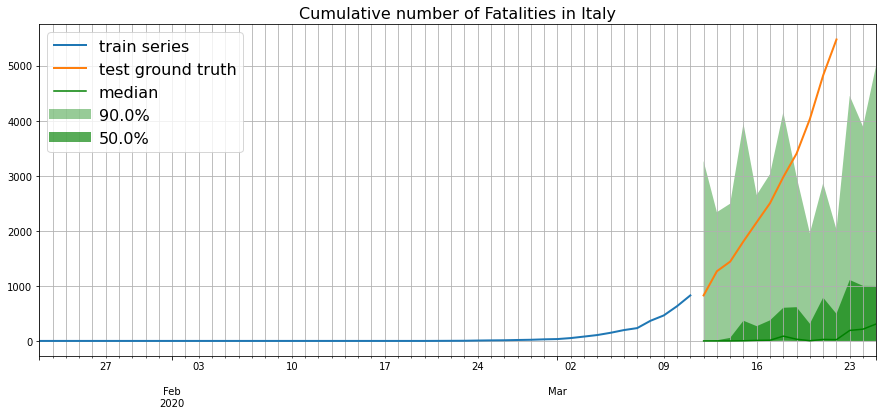

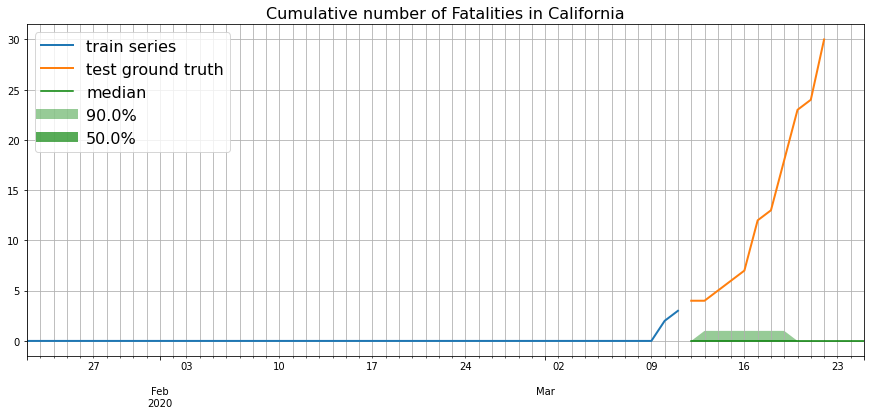

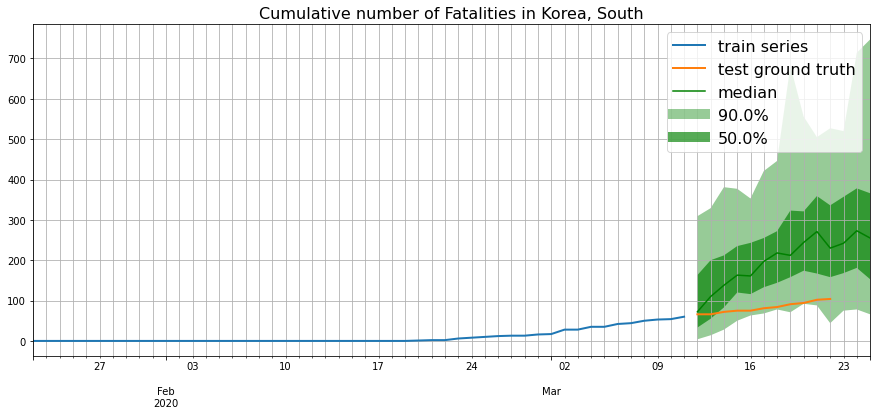

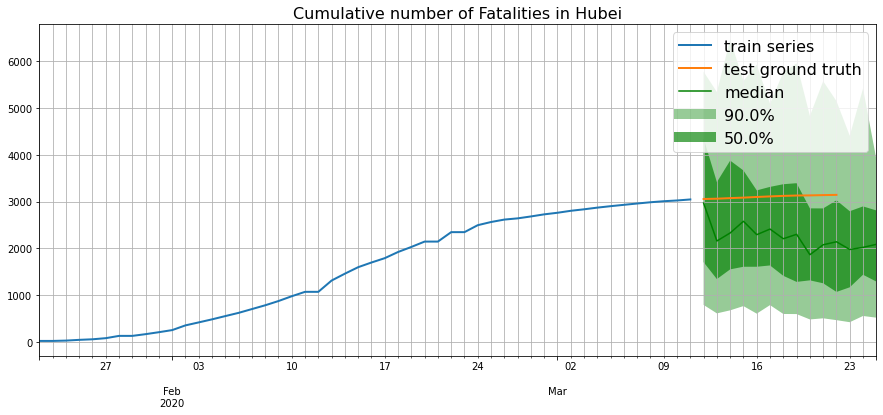

In [9]:
from gluonts.dataset.util import to_pandas
import matplotlib.pyplot as plt
from typing import List

def plot_forecast(
    predictor,
    location: List[str] = ['Italy', 'Italy'],
    target: str = 'Fatalities',
    cat_vars: typing.List[str] = ['Province/State', 'Country/Region'],
    real_vars: typing.List[str] = EMBED_VARS,
    log_preds: bool = False,
    fontsize: int = 16
):
    fig = plt.figure(figsize=(15, 6.1), facecolor="white",  edgecolor='k')

    # plot train observations, true observations from public test set, and forecasts
    location_tr = enc.transform(np.array(location).reshape(1,-1))
    tr_df = train_df[np.all((train_df[['Province/State', 'Country/Region']].values == location_tr), axis=1)]
    train_obs = ListDataset(
        [{
            FieldName.START: tr_df.index[0], 
            FieldName.TARGET: tr_df[target].values,
            FieldName.FEAT_STATIC_CAT: tr_df[cat_vars].values[0],
            FieldName.FEAT_STATIC_REAL: tr_df[real_vars].values[0]
        }],
        freq = "D",
    )
    te_df = test_df[np.all((test_df[['Province/State', 'Country/Region']].values == location_tr), axis=1)]
    test_gt = ListDataset(
        [{"start": te_df.index[0], "target": te_df[target].values}],
        freq = "D",
    )
    for train_series, gt, forecast in zip(train_obs, test_gt, predictor.predict(train_obs)):
        
        train_series = to_pandas(train_series)
        gt = to_pandas(gt)
        
        if log_preds:
            train_series = np.expm1(train_series)
            gt = np.expm1(gt)
            forecast.samples = np.expm1(forecast.samples)
        
        train_series.plot(linewidth=2, label = 'train series')
        gt.plot(linewidth=2, label = 'test ground truth')
        forecast.plot(color='g', prediction_intervals=[50.0, 90.0])
        
    plt.title(f'Cumulative number of {target} in {location[0]}', fontsize=fontsize)
    plt.legend(fontsize = fontsize)
    plt.grid(which='both')
    plt.show()
    
plot_forecast(predictor_fatalities, ['Italy', 'Italy'])
plot_forecast(predictor_fatalities, ['California', 'US'])
plot_forecast(predictor_fatalities, ['Korea, South', 'Korea, South'])
plot_forecast(predictor_fatalities, ['Hubei', 'China'])



# Calculate metrics on public test

In [10]:
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
import json

all_data = build_dataset(all_df)

# evaluate fatalities predictor
forecast_iterable, ts_iterable = make_evaluation_predictions(
    dataset=all_data,
    predictor=predictor_fatalities,
    num_samples=100
)
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(ts_iterable, forecast_iterable, num_series=len(all_data))
print('Fatalities Predictor Metrics: ')
print(json.dumps(agg_metrics, indent=4))

# evaluate confirmed cases predictor
forecast_iterable, ts_iterable = make_evaluation_predictions(
    dataset=all_data,
    predictor=predictor_cases,
    num_samples=100
)
agg_metrics, item_metrics = evaluator(ts_iterable, forecast_iterable, num_series=len(all_data))
print('Confirmed Cases Predictor Metrics: ')
print(json.dumps(agg_metrics, indent=4))

Running evaluation:   0%|          | 0/284 [00:00<?, ?it/s]

Fatalities Predictor Metrics: 
{
    "MSE": 26090.530917502518,
    "abs_error": 70423.0,
    "abs_target_sum": 107181.0,
    "abs_target_mean": 26.95699195171026,
    "seasonal_error": 0.2850581751377832,
    "MASE": 23.304857600438694,
    "sMAPE": 0.4548947847909565,
    "MSIS": 756.5236308484509,
    "QuantileLoss[0.1]": 18961.0,
    "Coverage[0.1]": 0.004024144869215291,
    "QuantileLoss[0.5]": 70423.0,
    "Coverage[0.5]": 0.012072434607645876,
    "QuantileLoss[0.9]": 72415.59999999999,
    "Coverage[0.9]": 0.11720321931589536,
    "RMSE": 161.52563548088122,
    "NRMSE": 5.991975505658501,
    "ND": 0.657047424450229,
    "wQuantileLoss[0.1]": 0.17690635467107044,
    "wQuantileLoss[0.5]": 0.657047424450229,
    "wQuantileLoss[0.9]": 0.6756384060607756,
    "mean_wQuantileLoss": 0.5031973950606917,
    "MAE_Coverage": 0.45556673373574785
}


Running evaluation: 100%|██████████| 284/284 [00:17<00:00, 16.46it/s]

Confirmed Cases Predictor Metrics: 
{
    "MSE": 20241.019785515025,
    "abs_error": 59768.0,
    "abs_target_sum": 107181.0,
    "abs_target_mean": 26.95699195171026,
    "seasonal_error": 0.2850581751377832,
    "MASE": 24.843940363282414,
    "sMAPE": 0.4869963792455672,
    "MSIS": 664.2246947488554,
    "QuantileLoss[0.1]": 25873.000000000004,
    "Coverage[0.1]": 0.03319919517102616,
    "QuantileLoss[0.5]": 59768.0,
    "Coverage[0.5]": 0.1290241448692153,
    "QuantileLoss[0.9]": 58645.4,
    "Coverage[0.9]": 0.3347585513078471,
    "RMSE": 142.2709379512029,
    "NRMSE": 5.277700798592874,
    "ND": 0.5576361481979082,
    "wQuantileLoss[0.1]": 0.24139539657215367,
    "wQuantileLoss[0.5]": 0.5576361481979082,
    "wQuantileLoss[0.9]": 0.5471622768960916,
    "mean_wQuantileLoss": 0.44873127388871786,
    "MAE_Coverage": 0.33433936955063714
}


In [ ]:
# generate submission csv

# aggregate fatalities
fatalities = []
for public_forecast, private_forecast in zip(
    predictor_fatalities.predict(training_data_fatalities),
    predictor_fatalities_all.predict(training_data_fatalities_all)
):
    # offset by 1 because last training date is March 24, want to start predicting at March 26
    fatalities.append(np.concatenate((public_forecast.median, private_forecast.median[1:])))

# aggregate cases
cases = []
for public_forecast, private_forecast in zip(
    predictor_cases.predict(training_data_cases),
    predictor_cases_all.predict(training_data_cases_all)
):
    # offset by 1 because last training date is March 24, want to start predicting at March 26
    cases.append(np.concatenate((public_forecast.median, private_forecast.median[1:])))

# load test csv 
sub_df = pd.read_csv("/root/data/test.csv")

# fill 'NaN' Province/State values with Country/Region values
sub_df['Province/State'] = sub_df['Province/State'].fillna(sub_df['Country/Region'])

# get forecast ids
ids = []
for _, df in sub_df.groupby(by=['Province/State', 'Country/Region']):
    ids.append(df['ForecastId'].values)

# create submission df
submission = pd.DataFrame(
    list(zip(
        np.array(ids).flatten(),
        np.array(cases).flatten(),
        np.array(fatalities).flatten()
    )), 
    columns = ['ForecastId', 'ConfirmedCases', 'Fatalities']
)
submission.to_csv('submission_dum.csv', index=False)

# Interrogate importance of covariates 

how - maybe model-agnostic method like SHAP values?, visualization of learned embeddings

In [ ]:
from sklearn import manifold
from matplotlib.ticker import NullFormatter

# get list of countries with most fatalities
def visualize_embedding(
    trained_net,
    sort_key: str = 'Fatalities',
    top_n: int = 10
):
    countries = train_all.groupby('Country/Region').sum().sort_values(
        by=sort_key, 
        ascending = False
    ).head(top_n).index.tolist()

    # visualize 2-D projection of learned Country/Region embedding space with TSNE
    embedding = trained_net.collect_params()[f'{trained_net.name}_featureembedder0_cat_1_embedding_weight'].data()
    proj = manifold.TSNE(init='pca', random_state = 0).fit_transform(embedding.asnumpy())

    # plot
    fig = plt.figure(figsize=(15, 6.1), facecolor="white",  edgecolor='k')
    ax = plt.gca()
    for country in countries:
        idx = np.where(enc.categories_[1] == country)[0][0]
        plt.scatter(
            proj[idx, 0], 
            proj[idx, 1], 
            cmap=plt.cm.Spectral, 
            label = country
        )
        ax.annotate(
            country, 
            (proj[idx, 0], proj[idx, 1]), 
            fontsize=16,
        )
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.title(f"TSNE Visualization of Learned 'Country/Region' Embedding Space", fontsize=16)
    plt.show()

visualize_embedding(trained_case_net, sort_key = 'ConfirmedCases')
visualize_embedding(all_fatality_net)